In [1]:
import os
import torch
import torchvision.models as models
import torchvision.transforms as transforms
from torch import nn, optim
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torchvision import datasets, transforms, models # add models to the list
from sklearn.metrics import classification_report

In [2]:
# check if GPU is available 
torch.cuda.is_available()

True

In [3]:
PROJECT_ROOT = os.getcwd()

In [4]:
train_path = PROJECT_ROOT +'/train/'
validation_path = PROJECT_ROOT +'/validation/'

In [5]:
# define transformers
train_transform = transforms.Compose([
        transforms.RandomAffine(degrees=0, shear=5, scale=(0.95,1.05)),
        transforms.RandomRotation(3),      
        transforms.RandomHorizontalFlip(p=0.5),  # reverse 50% of images
        transforms.RandomVerticalFlip(p=0.3),  # reverse 30% of images
        transforms.GaussianBlur(3, sigma=(0.1, 1.0)),
        transforms.Resize(224),             # resize shortest side to 224 pixels
        transforms.CenterCrop(224),         # crop longest side to 224 pixels at center
        transforms.ToTensor(),
        transforms.Normalize([0.5],[0.5])
    ])


valid_transform = transforms.Compose([
        transforms.Resize(224),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.5],[0.5])
    ])


In [6]:
import json
from torch.utils.data import Dataset
from PIL import Image
from glob import glob

In [7]:
# load annotation and get image path and labels
class TumorDataset(Dataset):
    def __init__(self, data_path, transform=None):
        
        self.samples = []
        self.label_map = {
            'no_tumor': 0,
            'tumor': 1
            }
        for label_name, label_value in self.label_map.items():
            folder_path = os.path.join(data_path, label_name)
            image_paths = glob(os.path.join(folder_path, '*'))

            for image_path in image_paths:
                self.samples.append((
                    image_path, label_value
                    ))   
            self.transform = transform

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        image_path, label = self.samples[idx]
        image = Image.open(image_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, label


In [8]:
train_data = TumorDataset(
    data_path = train_path,
    transform=train_transform
)
valid_data = TumorDataset(
    data_path = validation_path,
    transform = valid_transform   
)

In [9]:
# start to load pre-trained ResNet18 model and fine-tune
import os
import time
from tqdm import tqdm
import numpy as np
import random
import torch
import torch.nn as nn
from torchvision import models
from torchvision.models import resnet18, ResNet18_Weights
from torch.optim.lr_scheduler import ReduceLROnPlateau
import shutil

save_dir_resnet18= os.path.join(PROJECT_ROOT, 'ResNet18')
os.makedirs(save_dir_resnet18,exist_ok = True)

num_runs = 3
train_accuracies_all = []
valid_accuracies_all = []
train_losses_all = []
valid_losses_all = []
all_train_acc = []
all_val_acc =[]
all_train_loss = []
all_val_loss =[]
# track the best val loss of each run 
best_val_losses_all = []



for run in range(num_runs):
    print(f"\n===== Run {run+1} =====\n")
    torch.manual_seed(42 + run)
    torch.cuda.manual_seed(42 + run)
    np.random.seed(42 + run)
    random.seed(42 + run)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    train_loader = DataLoader(train_data, batch_size = 32, shuffle=True)
    valid_loader = DataLoader(valid_data, batch_size = 32, shuffle=True)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    # load pretrained ResNet18 model
    model = models.resnet18(weights=ResNet18_Weights.DEFAULT)
    # freeze all layers
    for param in model.parameters():
        param.requires_grad = False
    
    # unfreeze three block and fc
    for param in model.layer2.parameters():
        param.requires_grad = True
    for param in model.layer3.parameters():
        param.requires_grad = True
    for param in model.layer4.parameters():
        param.requires_grad = True
    model.fc = nn.Sequential(
        nn.Dropout(0.4),
        nn.Linear(model.fc.in_features, 2)
    
    )
    model = model.to(device)
   

    # define the loss and optimizer 
    criterion = nn.CrossEntropyLoss(label_smoothing=0.05)
    opt_resnet18 = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay = 1e-5)
    scheduler = ReduceLROnPlateau(opt_resnet18, mode = 'min', factor =0.5, patience=3, threshold=0.001)

    # train the model with early stopping
    
    best_val_acc = 0
    best_model_path_extension = os.path.join(save_dir_resnet18, f"best_resnet18_run{run+1}.pth")

    epochs = 35 # Keep the high epoch count, early stopping will decide when to stop
    patience =4 # Stop training if validation loss does not improve for 'patience' epochs
    min_delta = 0.001 # Minimum change to qualify as an improvement
    best_val_loss = float('inf') # Track best validation loss
    counter = 0 # Track consecutive epochs without improvement
    best_model_path= os.path.join(save_dir_resnet18, f'best_resnet18_run{run+1}.pth')

    train_losses = []
    valid_losses= []
    train_accuracies = []
    valid_accuracies= []

      # track best epoch metircs
    val_accuracy_at_best_loss = None
    train_accuracy_at_best_loss = None
    train_loss_at_best_loss = None
    val_loss_at_best_loss = None

    start_time = time.time()

    for epoch in range(epochs):
        model.train()
        epoch_train_loss = 0.0
        train_correct = 0
        total_train = 0
    
    # Run the training batches
        for b, (X_train, y_train) in enumerate(train_loader):
            b+=1
            X_train, y_train = X_train.to('cuda'), y_train.to('cuda')
        
            # forward pass
            outputs = model(X_train)
            loss = criterion(outputs, y_train)

            # backward propagation 
            opt_resnet18.zero_grad()
            loss.backward()
            opt_resnet18.step()

            # track loos and accuracy
            epoch_train_loss += loss.item()
            preds = outputs.argmax(dim=1)
            train_correct += (preds == y_train).sum().item()
            total_train += y_train.size(0)

            # optional debug
            if b%20 == 0:
                print(f"Batch {b}, Loss: {loss.item():.4f}")

        avg_train_loss = epoch_train_loss / len(train_loader)
        train_accuracy = train_correct / total_train

        train_losses.append(avg_train_loss)
        train_accuracies.append(train_accuracy)

        # validation part
        model.eval()
        epoch_val_loss = 0.0
        val_correct = 0
        total_val = 0

        with torch.no_grad():
            for X_val, y_val in valid_loader:
                X_val, y_val = X_val.to('cuda'), y_val.to('cuda')

                outputs = model(X_val)
                loss = criterion(outputs, y_val)

                epoch_val_loss += loss.item()
                preds = outputs.argmax(dim=1)
                val_correct += (preds == y_val).sum().item()
                total_val += y_val.size(0)
       
           
        avg_val_loss = epoch_val_loss / len(valid_loader)
        val_accuracy = val_correct / total_val

        valid_losses.append(avg_val_loss)
        valid_accuracies.append(val_accuracy)

  

        print(f"Epoch: {epoch+1} - Train Loss: {avg_train_loss:.4f}, Train Acc: {train_accuracy:.4g} | "
              f"Val Loss: {avg_val_loss:.4f}, Val Acc: {val_accuracy:.4f}")
        scheduler.step(avg_train_loss)
      
        
        # **Early stopping logic**
        if avg_val_loss < best_val_loss - min_delta:
            best_val_loss = avg_val_loss # Update best loss
            val_accuracy_at_best_loss = val_accuracy
            train_accuracy_at_best_loss = train_accuracy
            train_loss_at_best_loss = avg_train_loss
            val_loss_at_best_loss = avg_val_loss

            counter = 0 # Reset counter
            # save the best model for this run
            torch.save(model.state_dict(), best_model_path_extension)
            print(f"Best model saved at epoch {epoch+1}")
        else:
            counter += 1 # Increase counter
            if counter >= patience: # Stop if no improvement for 'patience' epochs
                print(f"Early stopping at epoch {epoch+1} (No improvement for {patience} epochs)")
                break
    #save metrics from each run
    all_train_acc.append(train_accuracy_at_best_loss)
    all_val_acc.append(val_accuracy_at_best_loss)
    all_train_loss.append(train_loss_at_best_loss)
    all_val_loss.append(val_loss_at_best_loss)   
    best_val_losses_all.append(best_val_loss)

    # save full per-epoch history
    train_accuracies_all.append(train_accuracies)
    valid_accuracies_all.append(valid_accuracies)
    train_losses_all.append(train_losses)
    valid_losses_all.append(valid_losses)

print(f'\nDuration: {time.time() - start_time:.0f} seconds') # Print time elapsed
# final results
print("\n===== Final Average Results ======\n")
print(f"Train Accuracy: {np.mean(all_train_acc):.4f} +- {np.std(all_train_acc):.4f}")
print(f"Valid Accuracy: {np.mean(all_val_acc):.4f} +- {np.std(all_val_acc):.4f}")
print(f"Train Loss: {np.mean(all_train_loss):.4f} +- {np.std(all_train_loss):.4f}")
print(f"Valid Loss: {np.mean(all_val_loss):.4f} +- {np.std(all_val_loss):.4f}")

# save only the best model across runs
best_run_idx = np.argmin(best_val_losses_all)
best_model_path = os.path.join(save_dir_resnet18, f"best_resnet18_run{best_run_idx + 1}.pth")
final_best_model_path = os.path.join(save_dir_resnet18, 'best_resnet18_overall.pth')
shutil.copy(best_model_path, final_best_model_path)
print(f"n\Best overall model was from run {best_run_idx + 1} with val loss {best_val_losses_all[best_run_idx]:.4f}")
print("\nsaved to:", os.path.relpath(final_best_model_path))



===== Run 1 =====

Batch 20, Loss: 0.1771
Batch 40, Loss: 0.1638
Batch 60, Loss: 0.2328
Epoch: 1 - Train Loss: 0.2534, Train Acc: 0.9373 | Val Loss: 0.1951, Val Acc: 0.9628
Best model saved at epoch 1
Batch 20, Loss: 0.1435
Batch 40, Loss: 0.1415
Batch 60, Loss: 0.1396
Epoch: 2 - Train Loss: 0.1599, Train Acc: 0.9875 | Val Loss: 0.1446, Val Acc: 0.9907
Best model saved at epoch 2
Batch 20, Loss: 0.1498
Batch 40, Loss: 0.1480
Batch 60, Loss: 0.1672
Epoch: 3 - Train Loss: 0.1611, Train Acc: 0.9866 | Val Loss: 0.1352, Val Acc: 0.9953
Best model saved at epoch 3
Batch 20, Loss: 0.1290
Batch 40, Loss: 0.1663
Batch 60, Loss: 0.1486
Epoch: 4 - Train Loss: 0.1543, Train Acc: 0.989 | Val Loss: 0.1369, Val Acc: 0.9930
Batch 20, Loss: 0.1343
Batch 40, Loss: 0.1260
Batch 60, Loss: 0.1404
Epoch: 5 - Train Loss: 0.1472, Train Acc: 0.9915 | Val Loss: 0.1329, Val Acc: 0.9953
Best model saved at epoch 5
Batch 20, Loss: 0.1320
Batch 40, Loss: 0.1273
Batch 60, Loss: 0.1284
Epoch: 6 - Train Loss: 0.1337,

In [10]:
# visulize train and valid loss
import matplotlib.pyplot as plt
import numpy as np

In [11]:
max_len = max(len(run) for run in train_accuracies_all)

In [12]:
def pad_to_max(arr_list, max_len):
    return np.array([np.pad(run, (0, max_len - len(run)), constant_values=np.nan) for run in arr_list])

train_accuracies_pad = pad_to_max(train_accuracies_all, max_len)
valid_accuracies_pad = pad_to_max(valid_accuracies_all, max_len)
train_losses_pad = pad_to_max(train_losses_all, max_len)
valid_losses_pad = pad_to_max(valid_losses_all, max_len)



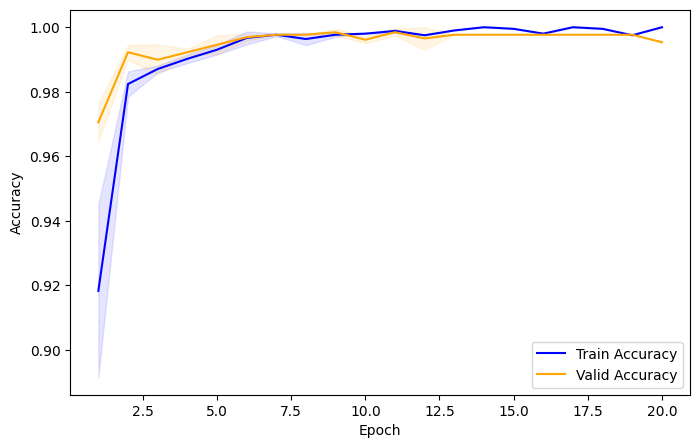

In [13]:

epochs = list(range(1, max_len + 1))
mean_train_acc = np.nanmean(train_accuracies_pad, axis=0)
std_train_acc = np.nanstd(train_accuracies_pad, axis=0)

mean_valid_acc = np.nanmean(valid_accuracies_pad, axis=0)
std_valid_acc = np.nanstd(valid_accuracies_pad, axis=0)


plt.figure(figsize = (8,5))
plt.plot(epochs, mean_train_acc, label='Train Accuracy', color = 'blue')
plt.fill_between(epochs, mean_train_acc - std_train_acc, mean_train_acc + std_train_acc, alpha = 0.1, color = 'blue')

plt.plot(epochs, mean_valid_acc, label='Valid Accuracy', color = 'orange')
plt.fill_between(epochs, mean_valid_acc - std_valid_acc, mean_valid_acc + std_valid_acc, alpha = 0.1, color = 'orange')

plt.title('')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
def pad_to_max(loss_list, max_len):
    return np.array([np.pad(run, (0, max_len - len(run)), constant_values=np.nan) for run in loss_list])


train_losses_pad = pad_to_max(train_losses_all, max_len)
valid_losses_pad = pad_to_max(valid_losses_all, max_len)

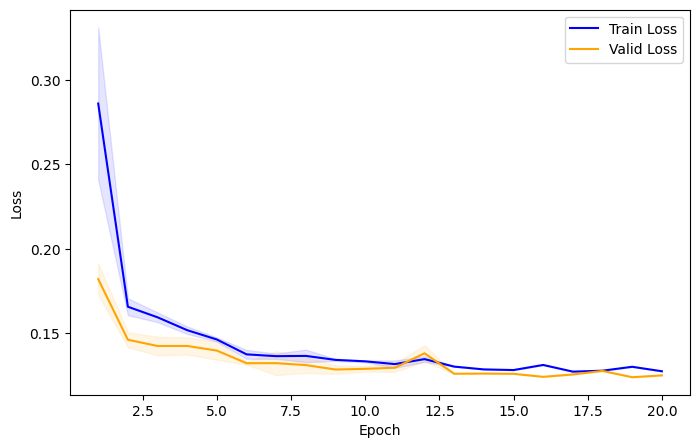

In [15]:
epochs = list(range(1, max_len + 1))
mean_train_loss = np.nanmean(train_losses_pad, axis=0)
std_train_loss = np.nanstd(train_losses_pad, axis=0)

mean_valid_loss = np.nanmean(valid_losses_pad, axis=0)
std_valid_loss = np.nanstd(valid_losses_pad,axis=0)

epochs = list(range(1, len(mean_train_loss)+1))

plt.figure(figsize = (8,5))
plt.plot(epochs, mean_train_loss, label='Train Loss', color = 'blue')
plt.fill_between(epochs, mean_train_loss - std_train_loss, mean_train_loss + std_train_loss, alpha = 0.1, color = 'blue')

plt.plot(epochs, mean_valid_loss, label='Valid Loss', color = 'orange')
plt.fill_between(epochs, mean_valid_loss - std_valid_loss, mean_valid_loss + std_valid_loss, alpha = 0.1, color = 'orange')

plt.title('')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [16]:
model_dir = os.path.join(PROJECT_ROOT, 'ResNet18')
model_filename = 'best_resnet18_overall.pth'
model_path = os.path.join(model_dir, model_filename)

In [17]:
model.load_state_dict(torch.load(model_path))
model  = model.to(device)
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [18]:
import seaborn as sns
model.eval()
all_preds = []
all_labels = []
with torch.no_grad():
    for images, labels in valid_loader:
        images = images.to('cuda')
        labels = labels.to('cuda')

        outputs = model(images)
        _, preds = torch.max(outputs,1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

In [19]:
print("classification_report:\n")
print(classification_report(all_labels, all_preds))

classification_report:

              precision    recall  f1-score   support

           0       1.00      0.98      0.99        59
           1       1.00      1.00      1.00       371

    accuracy                           1.00       430
   macro avg       1.00      0.99      1.00       430
weighted avg       1.00      1.00      1.00       430



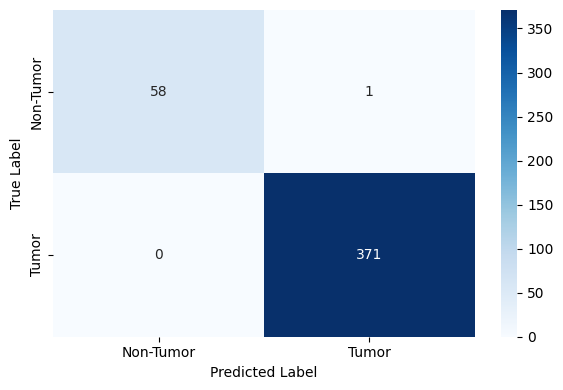

In [20]:
# confusion matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Non-Tumor', 'Tumor'],
            yticklabels=['Non-Tumor','Tumor'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('')
plt.tight_layout()
plt.show()